In [1]:
!pip install ucimlrepo
!pip install transformers==4.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.1
    Uninstalling transformers-4.40.1:
      Successfully uninstalled transformers-4.40.1


In [2]:
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from transformers import GPT2Model, AutoTokenizer, BertModel, BertTokenizer, GPT2Tokenizer
from torch.cuda.amp import autocast, GradScaler
import torchtext
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Частина 0. Створення і підготовка допоміжних функцій при роботі з даними і моделями

Створимо функції для виводу потрібних метрик і результатів роботи моделей відповідно до задання лабораторної роботи

In [4]:
def plot_metrics(y_test, y_pred_labels, y_pred, labels_list, num_classes, model_type, metric_type):
    accuracy = accuracy_score(y_test, y_pred_labels)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred_labels)
    f1 = f1_score(y_test, y_pred_labels, average='weighted')
    precision = precision_score(y_test, y_pred_labels, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred_labels, average='weighted')
    confusion = confusion_matrix(y_test, y_pred_labels)

    type_ = ''
    if metric_type == 0:
      type_ = 'rating/sentiment'
    elif metric_type == 2:
      type_ = 'effectiveness/benefits'
    else :
      type_ = 'sideEffects/side_effects'

    print(f"[{model_type}][{type_}] Accuracy:\t\t", accuracy)
    print(f"[{model_type}][{type_}] Balanced Accuracy:\t", balanced_accuracy)
    print(f"[{model_type}][{type_}] F1 Score:\t\t", f1)
    print(f"[{model_type}][{type_}] Precision:\t\t", precision)
    print(f"[{model_type}][{type_}] Recall:\t\t\t", recall)
    print(f"[{model_type}][{type_}] Confusion Matrix:\t\t")
    print(confusion)
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"[{model_type}][{type_}] Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels_list))
    plt.xticks(tick_marks, labels_list, rotation=45)
    plt.yticks(tick_marks, labels_list)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.subplot(1, 3, 2)
    roc_auc_scores_rnn = []
    for i in range(num_classes):
        roc_auc_score_class = roc_auc_score(y_test == i, y_pred[:, i])
        roc_auc_scores_rnn.append(roc_auc_score_class)

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test == i, y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (class {i}, AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'[{model_type}][{type_}] Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()
    print('\n\n')


Створимо функцію для виводу втрат моделі на навчальних і тестоих даних

In [5]:
def plotTrainTestCurves(train_loss, test_loss, model_type, metric_type):
    type_ = ''
    if metric_type == 0:
      type_ = 'rating/sentiment'
    elif metric_type == 2:
      type_ = 'effectiveness/benefits'
    else :
      type_ = 'sideEffects/side_effects'

    epochs = [i for i in range(1, len(train_loss)+1)]
    plt.plot(epochs, train_loss, 'b', label='Train loss')
    plt.plot(epochs, test_loss, 'r', label='Test loss')
    plt.title(f'Model [{model_type}][{type_}] Train/Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Для датафрейму який ми будемо завантажувати створимо також функцію очистки текста від зайвих і повторюваних слів, аби дати в подальшому йому можливість бути нормально токенізованим і не впливати на роботу моделі за рахунок частої зустрічі до прикладу пунктуаційних знаків в тексті, які заважатимуть моделі знаходити зміст для класифікації

In [6]:
def cleanText(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token.lower() for token in tokens]
    redundant_prepositions_words = stopwords.words("english")
    tokens = [token for token in tokens if token not in redundant_prepositions_words]
    tokenized_text = ' '.join(tokens)
    return tokenized_text


Створимо безпосередню функцію токенізації текста за для англійської мови та для токнів створимо словник

In [7]:
def TokenizeData(data):
    tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
    seq = [tokenizer(text) for text in data]
    vocab = torchtext.vocab.build_vocab_from_iterator(seq)
    seq = [torch.tensor([vocab[token] for token in s]) for s in seq]
    padd_seq = pad_sequence(seq, batch_first=True, padding_value=0)
    padd_seq = F.pad(padd_seq, (0, 100 - padd_seq.size(1)), value=0)
    return padd_seq

#Частина 1. Завантаження, аналіз та підготовка даних
Завантажимо Датасет та проаналізуємо його

In [8]:
drug_reviews_druglib_com = fetch_ucirepo(id=461)
X = drug_reviews_druglib_com.data.features

In [9]:
print(X.dtypes)
X

urlDrugName          object
rating                int64
effectiveness        object
sideEffects          object
condition            object
benefitsReview       object
sideEffectsReview    object
commentsReview       object
dtype: object


,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above
...,...,...,...,...,...,...,...,...
4138,accutane,7,Considerably Effective,Severe Side Effects,acne vulgaris,Detoxing effect by pushing out the system thro...,"Hairloss, extreme dry skin, itchiness, raises ...",Treatment period is 3 months/12 weeks. Dosage ...
4139,proair-hfa,10,Highly Effective,No Side Effects,asthma,"The albuterol relieved the constriction, irrit...",I have experienced no side effects.,I use the albuterol as needed because of aller...
4140,accutane,8,Considerably Effective,Moderate Side Effects,serve acne,Serve Acne has turned to middle,"Painfull muscles, problems with seeing at night","This drug is highly teratogenic ,females must ..."
4141,divigel,10,Highly Effective,No Side Effects,menopause,"My overall mood, sense of well being, energy l...",No side effects of any kind were noted or appa...,Divigel is a topically applied Bio-Identical H...


Оскільки перед нами стоїть задача класифікації колонок за їхніми відгуками/описом, а відгуки у нас присутні у 3ох стовпцях 'benefitsReview', 'sideEffectsReview',  'commentsReview', то логічно було об'єднати ці всі колонки в один стовпець з текстами відгуків і почистити їх від зайвих елементів з токенізаціює та навчанням моделей в подальшому

In [10]:
X['text_review'] = X['benefitsReview'] + ' ' + X['sideEffectsReview'] + ' ' + X['commentsReview']
X

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,text_review
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",slowed the progression of left ventricular dys...
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest...",Although this type of birth control has more c...
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...,I was used to having cramps so badly that they...
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...,The acid reflux went away for a few months aft...
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above,I think that the Lyrica was starting to help w...
...,...,...,...,...,...,...,...,...,...
4138,accutane,7,Considerably Effective,Severe Side Effects,acne vulgaris,Detoxing effect by pushing out the system thro...,"Hairloss, extreme dry skin, itchiness, raises ...",Treatment period is 3 months/12 weeks. Dosage ...,Detoxing effect by pushing out the system thro...
4139,proair-hfa,10,Highly Effective,No Side Effects,asthma,"The albuterol relieved the constriction, irrit...",I have experienced no side effects.,I use the albuterol as needed because of aller...,"The albuterol relieved the constriction, irrit..."
4140,accutane,8,Considerably Effective,Moderate Side Effects,serve acne,Serve Acne has turned to middle,"Painfull muscles, problems with seeing at night","This drug is highly teratogenic ,females must ...",Serve Acne has turned to middle Painfull muscl...
4141,divigel,10,Highly Effective,No Side Effects,menopause,"My overall mood, sense of well being, energy l...",No side effects of any kind were noted or appa...,Divigel is a topically applied Bio-Identical H...,"My overall mood, sense of well being, energy l..."


Проведемо sentiment аналіз target колонок для класифікації

In [11]:
print(X.groupby('rating').size())
print(X.groupby('effectiveness').size())
print(X.groupby('sideEffects').size())

rating
1     420
2     136
3     195
4     151
5     226
6     215
7     471
8     748
9     613
10    968
dtype: int64
effectiveness
Considerably Effective    1238
Highly Effective          1741
Ineffective                329
Marginally Effective       263
Moderately Effective       572
dtype: int64
sideEffects
Extremely Severe Side Effects     255
Mild Side Effects                1349
Moderate Side Effects             850
No Side Effects                  1198
Severe Side Effects               491
dtype: int64


Бачимо, що деякі класи попадаються частіше за інші і в загальному дані можна згрупувати і зробити ще менше класів, так до прикладу рейтинг ліків в діапазоні від 0 до 4 будемо вважати негативним, від 4 до 7 нейтральним та від 7 до 10 позитивним, це групування класів дозволить зменшити їхню кількість і за рахунок цього допоможе збільшити точність класифікації. З точки зору sentiment аналізу це можна обгрунтувати наступним чином, що рейтинг нижче 4 зазвичай залишають незадоволені клієнти, в діапазоні від 4 до 7 клієнти, які нейтрально ставляться до даних ліків, і від 7 до 10 ті кому ліки були корисними
<br/>

Аналогічно зробимо і з колонкою effectiveness, адже ліки можуть бути неефективними взагалі і не мати ніякого ефекту на особу, яка їх споживає, слабо ефективними і не сильно знімати симптоми, і сильно ефективними і боротися з симптомами хвороби від якої вони були призначеннні. відповідно згрупувавши їх по даних значення ми з 5ти класі отримає 3, що спрощить класифікацію і збільшить точність.
<br/>

Що ж до побічних ефектів, то тут можна застосувати бінарну класифікацію на те чи мала особа після вживання ліків побічні ефекти чи ні, і відповідно за цими параметрами також згрупувати дані.




In [12]:
def classify_new_category_effectiveness(effectiveness):
    if effectiveness == 'Ineffective':
        return 'ineffective'
    elif effectiveness in ['Marginally', 'Moderately Effective']:
        return 'marginally'
    elif effectiveness in ['Highly Effective', 'Considerably Effective']:
        return 'highly_effective'


def classify_new_category_sideeffects(sideEffects):
    if sideEffects == 'No Side Effects':
        return 'no'
    elif sideEffects in ['Mild Side Effects', 'Moderate Side Effects', 'Severe Side Effects', 'Extremely Severe Side Effects']:
        return 'severe'


In [13]:
X['sentiment'] = pd.cut(X['rating'], bins=[0, 4, 5, 10], labels=['negative', 'neutral', 'positive'], include_lowest=True)
X['benefits'] = X['effectiveness'].apply(classify_new_category_effectiveness)
X['side_effects'] = X['sideEffects'].apply(classify_new_category_sideeffects)
X.head(15)

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,text_review,sentiment,benefits,side_effects
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",slowed the progression of left ventricular dys...,negative,highly_effective,severe
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest...",Although this type of birth control has more c...,negative,highly_effective,severe
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...,I was used to having cramps so badly that they...,positive,highly_effective,no
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...,The acid reflux went away for a few months aft...,negative,None,severe
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above,I think that the Lyrica was starting to help w...,negative,None,severe
5,propecia,1,Ineffective,Severe Side Effects,hair loss,"after taking propecia for over a year, startin...","Low sex drive, before i started taking this dr...",one pill once daily,"after taking propecia for over a year, startin...",negative,ineffective,severe
6,vyvanse,9,Highly Effective,Mild Side Effects,add,"My mood has noticably improved, I have more en...","a few experiences of nausiea, heavy moodswings...",I had began taking 20mg of Vyvanse for three m...,"My mood has noticably improved, I have more en...",positive,highly_effective,severe
7,elavil,10,Considerably Effective,No Side Effects,depression,Although this drug was originally prescribed f...,None.,"One a day, taken about an hour before bedtime.",Although this drug was originally prescribed f...,positive,highly_effective,no
8,xanax,10,Highly Effective,No Side Effects,panic disorder,This simply just works fast and without any of...,I really don't have any side effects other tha...,I first started taking this at 3 times per day...,This simply just works fast and without any of...,positive,highly_effective,no
9,claritin,1,Ineffective,Extremely Severe Side Effects,allergies,none - did nothing to help allergies. i just h...,I had some horrifying mental and physical side...,took one 10 mg pill nightly.,none - did nothing to help allergies. i just h...,negative,ineffective,severe


Отримані колонки для класифікації, і тексти відгуків на основі яких класифікуватимемо загрузимо у нові датафрейми і займемося препроцесінгом і підготовкою даних

In [14]:
df = X[['text_review', 'sentiment']]
df2 = X[['text_review', 'benefits']]
df3 = X[['text_review', 'side_effects']]

In [15]:
labels_unique = [['negative', 'neutral', 'positive'], ['ineffective', 'marginally', 'highly_effective'], ['no', 'severe']]

In [16]:
columns = ['text_review']
for column in columns:
    df.loc[:, column] = df[column].astype(str)
    df2.loc[:, column] = df2[column].astype(str)
    df3.loc[:, column] = df3[column].astype(str)

    df.loc[:, column] = df[column].apply(cleanText)
    df2.loc[:, column] = df2[column].apply(cleanText)
    df3.loc[:, column] = df3[column].apply(cleanText)

In [17]:
nclasses = df['sentiment'].nunique()
nclasses2 = df2['benefits'].nunique()
nclasses3 = df3['side_effects'].nunique()
nclasses_ = [nclasses, nclasses2, nclasses3]
print(nclasses_)

[3, 3, 2]


Загрузимо токенізатори і pretrained моделі GPT2, BERT аби в подальшому використати їх для навчання на даних

In [18]:
tokenizerGPT = GPT2Tokenizer.from_pretrained('gpt2')
tokenizerGPT.add_special_tokens({'pad_token': '[PAD]'})
tokenizerGPT.pad_token = '[PAD]'
tokenizerBERT = BertTokenizer.from_pretrained('bert-base-uncased')

model_gpt = GPT2Model.from_pretrained('gpt2').to(device)
model_gpt.resize_token_embeddings(len(tokenizerGPT))
model_bert = BertModel.from_pretrained('bert-base-uncased').to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Отримані дані розділимо на навчальні і тестові та токенізуємо їх та завантажемо в тензори та датасети, окремо від усіх даних завантжемо дані для GPT2, BERT

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['text_review'],df['sentiment'], test_size=0.3, shuffle=False)
X_train2, X_test2, y_train2, y_test2 = train_test_split(df2['text_review'],df2['benefits'], test_size=0.3, shuffle=False)
X_train3, X_test3, y_train3, y_test3 = train_test_split(df3['text_review'],df3['side_effects'], test_size=0.3, shuffle=False)

In [20]:
X_train_gpt, X_test_gpt, y_train_gpt, y_test_gpt = train_test_split(df['text_review'], df['sentiment'], test_size=0.3, shuffle=True)
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(df['text_review'], df['sentiment'], test_size=0.3, shuffle=True)

X_train2_gpt, X_test2_gpt, y_train2_gpt, y_test2_gpt = train_test_split(df2['text_review'], df2['benefits'], test_size=0.3, shuffle=True)
X_train2_bert, X_test2_bert, y_train2_bert, y_test2_bert = train_test_split(df2['text_review'], df2['benefits'], test_size=0.3, shuffle=True)

X_train3_gpt, X_test3_gpt, y_train3_gpt, y_test3_gpt = train_test_split(df3['text_review'], df3['side_effects'], test_size=0.3, shuffle=True)
X_train3_bert, X_test3_bert, y_train3_bert, y_test3_bert = train_test_split(df3['text_review'], df3['side_effects'], test_size=0.3, shuffle=True)

In [21]:
X_train = TokenizeData(X_train)
X_test = TokenizeData(X_test)
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

X_train2 = TokenizeData(X_train2)
X_test2 = TokenizeData(X_test2)
y_train2 = pd.get_dummies(y_train2).values
y_test2 = pd.get_dummies(y_test2).values

X_train3 = TokenizeData(X_train3)
X_test3 = TokenizeData(X_test3)
y_train3 = pd.get_dummies(y_train3).values
y_test3 = pd.get_dummies(y_test3).values

X_ = [X_train, X_test, X_train2, X_test2, X_train3, X_test3]
y_ = [y_train, y_test, y_train2, y_test2, y_train3, y_test3]

In [22]:
#GPT
train_inputs_gpt = tokenizerGPT([str(i) for i in X_train_gpt.values] , return_tensors='pt', truncation=True, padding="max_length", max_length=512)
test_inputs_gpt = tokenizerGPT([str(i) for i in X_test_gpt.values], return_tensors='pt', truncation=True, padding="max_length", max_length=512)
y_train_gpt_ = pd.get_dummies(y_train_gpt).values
y_test_gpt_ = pd.get_dummies(y_test_gpt).values

train2_inputs_gpt = tokenizerGPT([str(i) for i in X_train2_gpt.values] , return_tensors='pt', truncation=True, padding="max_length", max_length=512)
test2_inputs_gpt = tokenizerGPT([str(i) for i in X_test2_gpt.values], return_tensors='pt', truncation=True, padding="max_length", max_length=512)
y_train2_gpt_ = pd.get_dummies(y_train2_gpt).values
y_test2_gpt_ = pd.get_dummies(y_test2_gpt).values

train3_inputs_gpt = tokenizerGPT([str(i) for i in X_train3_gpt.values] , return_tensors='pt', truncation=True, padding="max_length", max_length=512)
test3_inputs_gpt = tokenizerGPT([str(i) for i in X_test3_gpt.values], return_tensors='pt', truncation=True, padding="max_length", max_length=512)
y_train3_gpt_ = pd.get_dummies(y_train3_gpt).values
y_test3_gpt_ = pd.get_dummies(y_test3_gpt).values

#BERT
train_encodings_bert = tokenizerBERT(list(X_train_bert), truncation=True, padding=True, return_tensors='pt')
test_encodings_bert = tokenizerBERT(list(X_test_bert), truncation=True, padding=True, return_tensors='pt')
y_train_onehot_bert = pd.get_dummies(y_train_bert).values
y_test_onehot_bert = pd.get_dummies(y_test_bert).values

train_encodings2_bert = tokenizerBERT(list(X_train2_bert), truncation=True, padding=True, return_tensors='pt')
test_encodings2_bert = tokenizerBERT(list(X_test2_bert), truncation=True, padding=True, return_tensors='pt')
y_train2_onehot_bert = pd.get_dummies(y_train2_bert).values
y_test2_onehot_bert = pd.get_dummies(y_test2_bert).values

train_encodings3_bert = tokenizerBERT(list(X_train3_bert), truncation=True, padding=True, return_tensors='pt')
test_encodings3_bert = tokenizerBERT(list(X_test3_bert), truncation=True, padding=True, return_tensors='pt')
y_train3_onehot_bert = pd.get_dummies(y_train3_bert).values
y_test3_onehot_bert = pd.get_dummies(y_test3_bert).values

## Частина 2. Створення моделей та їхне навчання

Створимо 1 шарову модель RNN з функцією класифікації SoftMax  

In [23]:
class RNN(nn.Module):
    def __init__(self, vocab_size, input_embedding_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, input_embedding_dim)
        self.rnn = nn.RNN(input_embedding_dim, hidden_dim, dropout=0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        output = self.fc(output[:, -1, :])
        output = self.softmax(output)
        return output


Створимо 2 шарову модель GRU з  дропаут шарами, аби уникнути перенавчання моделі

In [24]:
class GRU(nn.Module):
    def __init__(self, vocab_size, input_embedding_dim, hidden_dim, output_dim):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, input_embedding_dim)
        self.gru1 = nn.GRU(input_embedding_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.gru2 = nn.GRU(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.gru1(embedded)
        output = self.dropout1(output)
        output, hidden = self.gru2(output)
        output = self.dropout2(output)
        output = self.fc(output[:, -1, :])
        return output

Аналогічно дл GRU сторимо 2шарову LSTM та 1 лінійним шаром, що слугуватиме виходом мережі

In [25]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, input_embedding_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, input_embedding_dim)
        self.lstm1 = nn.LSTM(input_embedding_dim, hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm1(embedded)
        output, _ = self.lstm2(output)
        output = self.fc(output[:, -1, :])
        return output

На основі завантаженої pretrained моделі GPT2 створимо власну модель, і додамо їй один лінійний вихідний шар з кількістю вихідних параметрів

In [26]:
class GPT2(nn.Module):
    def __init__(self, gpt2_model, num_labels):
        super(GPT2, self).__init__()
        self.gpt2 = gpt2_model
        self.classifier = nn.Linear(self.gpt2.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[0][:, 0, :]
        logits = self.classifier(pooled_output)
        return logits

На основі завантаженої pretrained моделі BERT створимо власну модель, і додамо їй один лінійний вихідний шар з кількістю вихідних параметрів, а також додамо Dropout шар для боротьби з перенавчанням

In [27]:
class BERT(nn.Module):
    def __init__(self, bert_model, num_labels):
        super(BERT, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

Створимо функцію тернування/тестування для перших 3ох моделей

In [28]:
def train_test(model, train_loader, test_loader, optimizer, criterion, num_epochs=1):
    model.to(device)
    train_losses = []
    test_losses = []
    y_train_pred = []
    y_test_pred = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        predictions_train = []
        true_labels_train = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predictions_train.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            true_labels_train.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        predictions_test = []
        true_labels_test = []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                predictions_test.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                true_labels_test.extend(targets.cpu().numpy())

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        accuracy_train = accuracy_score(true_labels_train, predictions_train)
        accuracy_test = accuracy_score(true_labels_test, predictions_test)
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {accuracy_train:.4f}, Test Accuracy: {accuracy_test:.4f}')

        y_train_pred = np.array(predictions_train)
        y_test_pred = np.array(predictions_test)

    return  train_losses, test_losses, y_train_pred, y_test_pred

Створимо функцію навчання для pretrained моделей адже логіка їхнього навчання і оцінки дещо відрізняється від звичайних моделей, також для прискорення роботи і навчання використаємо CUDA Scaler для Mixed Precision Training

In [29]:
def test_train_pretrained(model, train_loader, test_loader, optimizer, criterion, scaler, num_epochs=2):
    model.to(device)
    train_losses = []
    test_losses = []
    y_train_pred = []
    y_test_pred = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        predictions_train = []
        true_labels_train = []
        for input_ids, attention_mask, targets in train_loader:
            input_ids, attention_mask, targets = input_ids.to(device), attention_mask.to(device), targets.to(device)
            optimizer.zero_grad()
            with autocast():
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            predictions_train.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels_train.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        predictions_test = []
        true_labels_test = []
        with torch.no_grad():
            for input_ids, attention_mask, targets in test_loader:
                input_ids, attention_mask, targets = input_ids.to(device), attention_mask.to(device), targets.to(device)
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, targets)
                test_loss += loss.item()
                predictions_test.extend(torch.argmax(logits, dim=1).cpu().numpy())
                true_labels_test.extend(targets.cpu().numpy())

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        accuracy_train = accuracy_score(true_labels_train, predictions_train)
        accuracy_test = accuracy_score(true_labels_test, predictions_test)
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {accuracy_train:.4f}, Test Accuracy: {accuracy_test:.4f}')

        y_train_pred = np.array(predictions_train)
        y_test_pred = np.array(predictions_test)

    return train_losses, test_losses, y_train_pred, y_test_pred


In [30]:
def evaluate(model, X_test):
    model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        y_pred = model(X_test)

    return y_pred.cpu().numpy()

In [31]:
def evaluate_model(model, test_dataloader, device, labels_list, num_classes, model_type, metric_type):
    true_labels = []
    predicted_labels = []
    predicted_logits = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]
            logits = model(input_ids, attention_mask)
            _, predicted = torch.max(logits, dim=1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            predicted_logits.extend(logits.cpu().numpy())

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    predicted_logits = np.array(predicted_logits)

    plot_metrics(true_labels, predicted_labels, predicted_logits, labels_list, num_classes, model_type, metric_type)


Завантажимо отримані дані в тензори для подальшого їх використання моделями під час тренування

In [32]:
y_train_labels = np.argmax(y_[0], axis=1)
y_test_labels = np.argmax(y_[1], axis=1)
y_train_tensor = torch.tensor(y_train_labels).long()
y_test_tensor = torch.tensor(y_test_labels).long()

y_train_labels2 = np.argmax(y_[2], axis=1)
y_test_labels2 = np.argmax(y_[3], axis=1)
y_train_tensor2 = torch.tensor(y_train_labels2).long()
y_test_tensor2 = torch.tensor(y_test_labels2).long()

y_train_labels3 = np.argmax(y_[4], axis=1)
y_test_labels3 = np.argmax(y_[5], axis=1)
y_train_tensor3 = torch.tensor(y_train_labels3).long()
y_test_tensor3 = torch.tensor(y_test_labels3).long()

y_tensor_ = [y_train_tensor, y_test_tensor, y_train_tensor2, y_test_tensor2, y_train_tensor3, y_test_tensor3]

In [33]:
#GPT
y_train_labels_gpt = np.argmax(y_train_gpt_, axis=1)
y_test_labels_gpt = np.argmax(y_test_gpt_, axis=1)
y_train_tensor_gpt = torch.tensor(y_train_labels_gpt).long()
y_test_tensor_gpt = torch.tensor(y_test_labels_gpt).long()

y_train2_labels_gpt = np.argmax(y_train2_gpt_, axis=1)
y_test2_labels_gpt = np.argmax(y_test2_gpt_, axis=1)
y_train2_tensor_gpt = torch.tensor(y_train2_labels_gpt).long()
y_test2_tensor_gpt = torch.tensor(y_test2_labels_gpt).long()

y_train3_labels_gpt = np.argmax(y_train3_gpt_, axis=1)
y_test3_labels_gpt = np.argmax(y_test3_gpt_, axis=1)
y_train3_tensor_gpt = torch.tensor(y_train3_labels_gpt).long()
y_test3_tensor_gpt = torch.tensor(y_test3_labels_gpt).long()

#BERT
y_train_tensor_bert = torch.tensor(np.argmax(y_train_onehot_bert, axis=1)).long()
y_test_tensor_bert = torch.tensor(np.argmax(y_test_onehot_bert, axis=1)).long()

y_train2_tensor_bert = torch.tensor(np.argmax(y_train2_onehot_bert, axis=1)).long()
y_test2_tensor_bert = torch.tensor(np.argmax(y_test2_onehot_bert, axis=1)).long()

y_train3_tensor_bert = torch.tensor(np.argmax(y_train3_onehot_bert, axis=1)).long()
y_test3_tensor_bert = torch.tensor(np.argmax(y_test3_onehot_bert, axis=1)).long()

Задамо гіперпараметри мережі та створимо датасети

In [34]:
VOCABULARY_SIZE = 15000
LEARNING_RATE = 0.001
BATCH_SIZE = 16
GPT_BATCH_SIZE = 4
BERT_BATCH_SIZE = 8
HIDDEN_LAYER_SIZE = 32
EPOCHS = 2
INPUT_SIZE = 128

model_classes = {
    'RNN': RNN,
    'GRU': GRU,
    'LSTM': LSTM,
    "GPT": GPT2,
    "BERT": BERT
}
models = {
    "GPT": model_gpt,
    "BERT": model_bert
}


datasets = [
  TensorDataset(torch.tensor(X_[0]).clone().detach().long(), y_tensor_[0]),
  TensorDataset(torch.tensor(X_[1]).clone().detach().long(), y_tensor_[1]),

  TensorDataset(torch.tensor(X_[2]).clone().detach().long(), y_tensor_[2]),
  TensorDataset(torch.tensor(X_[3]).clone().detach().long(), y_tensor_[3]),

  TensorDataset(torch.tensor(X_[4]).clone().detach().long(), y_tensor_[4]),
  TensorDataset(torch.tensor(X_[5]).clone().detach().long(), y_tensor_[5]),
]

loaders = [
    DataLoader(dataset=datasets[0], batch_size=BATCH_SIZE, shuffle=True),
    DataLoader(dataset=datasets[1], batch_size=BATCH_SIZE, shuffle=False),

    DataLoader(dataset=datasets[2], batch_size=BATCH_SIZE, shuffle=True),
    DataLoader(dataset=datasets[3], batch_size=BATCH_SIZE, shuffle=False),

    DataLoader(dataset=datasets[4], batch_size=BATCH_SIZE, shuffle=True),
    DataLoader(dataset=datasets[5], batch_size=BATCH_SIZE, shuffle=False),
]


#GPT
datasets_gpt = [
    TensorDataset(train_inputs_gpt['input_ids'], train_inputs_gpt['attention_mask'], y_train_tensor_gpt),
    TensorDataset(test_inputs_gpt['input_ids'], test_inputs_gpt['attention_mask'], y_test_tensor_gpt),

    TensorDataset(train2_inputs_gpt['input_ids'], train2_inputs_gpt['attention_mask'], y_train2_tensor_gpt),
    TensorDataset(test2_inputs_gpt['input_ids'], test2_inputs_gpt['attention_mask'], y_test2_tensor_gpt),

    TensorDataset(train3_inputs_gpt['input_ids'], train3_inputs_gpt['attention_mask'], y_train3_tensor_gpt),
    TensorDataset(test3_inputs_gpt['input_ids'], test3_inputs_gpt['attention_mask'], y_test3_tensor_gpt)
]

#BERT
datasets_bert =  [
    TensorDataset(train_encodings_bert['input_ids'], train_encodings_bert['attention_mask'], y_train_tensor_bert),
    TensorDataset(test_encodings_bert['input_ids'], test_encodings_bert['attention_mask'], y_test_tensor_bert),

    TensorDataset(train_encodings2_bert['input_ids'], train_encodings2_bert['attention_mask'], y_train2_tensor_bert),
    TensorDataset(test_encodings2_bert['input_ids'], test_encodings2_bert['attention_mask'], y_test2_tensor_bert),

    TensorDataset(train_encodings3_bert['input_ids'], train_encodings3_bert['attention_mask'], y_train3_tensor_bert),
    TensorDataset(test_encodings3_bert['input_ids'], test_encodings3_bert['attention_mask'], y_test3_tensor_bert)
]


loader = {
    'GPT':  [
              DataLoader(datasets_gpt[0], batch_size=GPT_BATCH_SIZE, shuffle=True, num_workers=2),
              DataLoader(datasets_gpt[1], batch_size=GPT_BATCH_SIZE, num_workers=2),

              DataLoader(datasets_gpt[2], batch_size=GPT_BATCH_SIZE, shuffle=True, num_workers=2),
              DataLoader(datasets_gpt[3], batch_size=GPT_BATCH_SIZE, num_workers=2),

              DataLoader(datasets_gpt[4], batch_size=GPT_BATCH_SIZE, shuffle=True, num_workers=2),
              DataLoader(datasets_gpt[5], batch_size=GPT_BATCH_SIZE, num_workers=2)
            ],

    'BERT': [
              DataLoader(datasets_bert[0], batch_size=BERT_BATCH_SIZE, shuffle=True, num_workers=2),
              DataLoader(datasets_bert[1], batch_size=BERT_BATCH_SIZE, num_workers=2),

              DataLoader(datasets_bert[2], batch_size=BERT_BATCH_SIZE, shuffle=True, num_workers=2),
              DataLoader(datasets_bert[3], batch_size=BERT_BATCH_SIZE, num_workers=2),

              DataLoader(datasets_bert[4], batch_size=BERT_BATCH_SIZE, shuffle=True, num_workers=2),
              DataLoader(datasets_bert[5], batch_size=BERT_BATCH_SIZE, num_workers=2)
            ]
}




<ipython-input-34-be4daf02e164>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  TensorDataset(torch.tensor(X_[0]).clone().detach().long(), y_tensor_[0]),
<ipython-input-34-be4daf02e164>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  TensorDataset(torch.tensor(X_[1]).clone().detach().long(), y_tensor_[1]),
<ipython-input-34-be4daf02e164>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  TensorDataset(torch.tensor(X_[2]).clone().detach().long(), y_tensor_[2]),
<ipython-input-34-be4daf02e164>:28: UserWarning: To copy construct from a te

Запустимо моделі на виконання та порівняємо отримані результати

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/2, Train Loss: 0.8534, Test Loss: 0.8458, Train Accuracy: 0.7076, Test Accuracy: 0.7064
Epoch 2/2, Train Loss: 0.8187, Test Loss: 0.8444, Train Accuracy: 0.7345, Test Accuracy: 0.7072


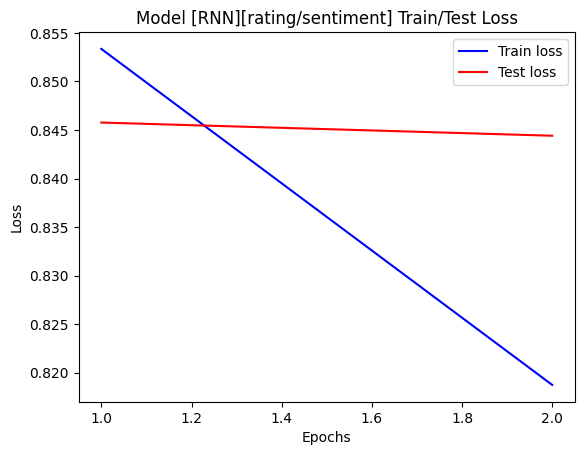

[RNN][rating/sentiment] Accuracy:		 0.7071600965406275
[RNN][rating/sentiment] Balanced Accuracy:	 0.33567999746306576
[RNN][rating/sentiment] F1 Score:		 0.5905500369959468
[RNN][rating/sentiment] Precision:		 0.6743608869865422
[RNN][rating/sentiment] Recall:			 0.7071600965406275
[RNN][rating/sentiment] Confusion Matrix:		
[[  3   1 283]
 [  0   0  77]
 [  1   2 876]]


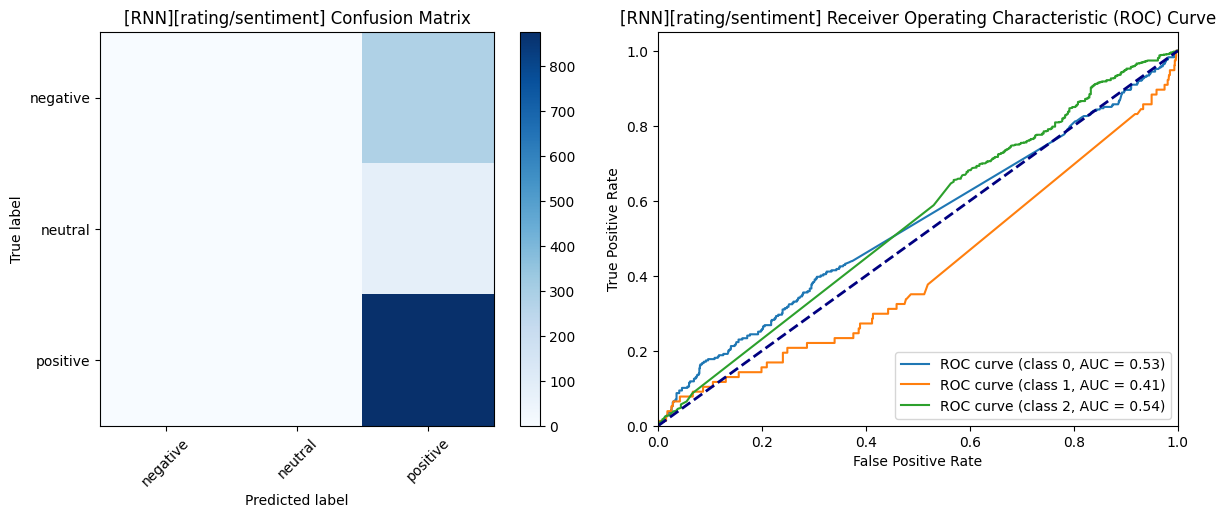




Epoch 1/2, Train Loss: 0.7442, Test Loss: 0.7643, Train Accuracy: 0.7234, Test Accuracy: 0.7056
Epoch 2/2, Train Loss: 0.7184, Test Loss: 0.7644, Train Accuracy: 0.7362, Test Accuracy: 0.7056


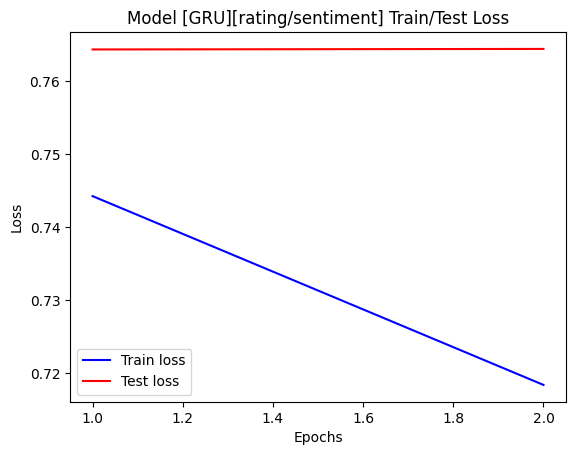

[GRU][rating/sentiment] Accuracy:		 0.7055510860820595
[GRU][rating/sentiment] Balanced Accuracy:	 0.33257489571482746
[GRU][rating/sentiment] F1 Score:		 0.5856273887310012
[GRU][rating/sentiment] Precision:		 0.5005483492059163
[GRU][rating/sentiment] Recall:			 0.7055510860820595
[GRU][rating/sentiment] Confusion Matrix:		
[[  0   2 285]
 [  0   0  77]
 [  1   1 877]]


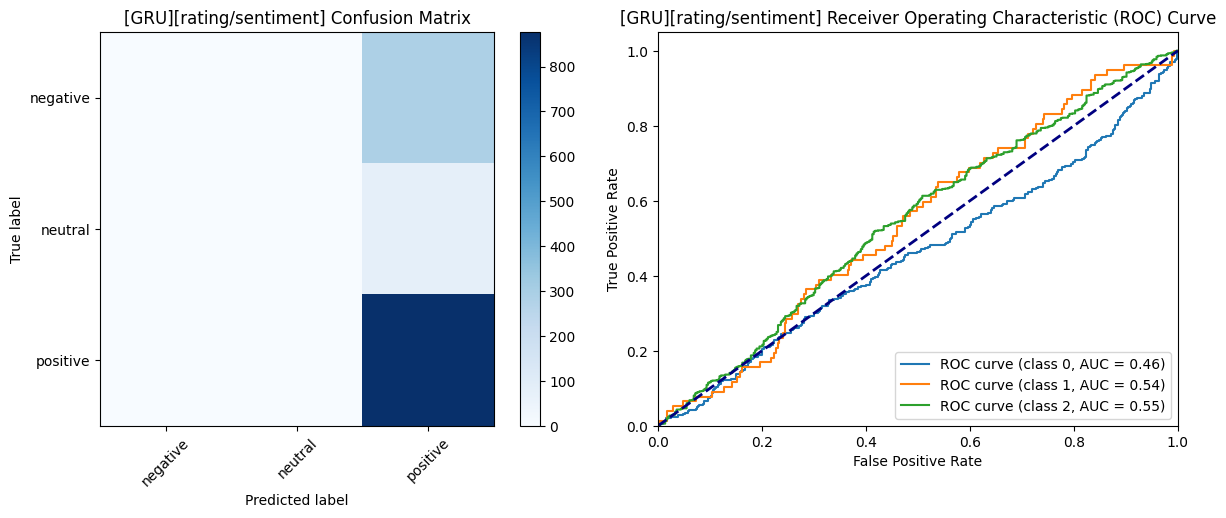




Epoch 1/2, Train Loss: 0.7593, Test Loss: 0.7659, Train Accuracy: 0.7069, Test Accuracy: 0.7047
Epoch 2/2, Train Loss: 0.7168, Test Loss: 0.7670, Train Accuracy: 0.7355, Test Accuracy: 0.7072


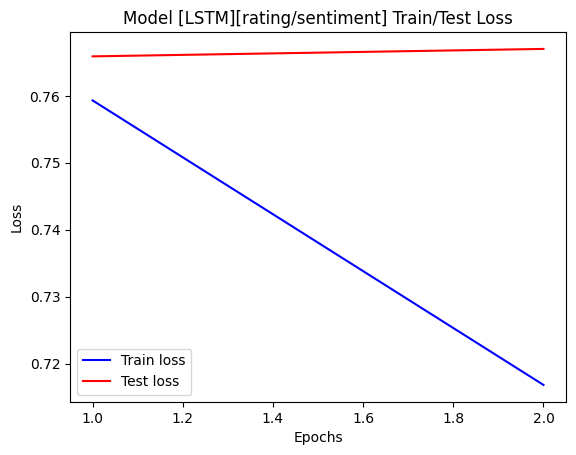

[LSTM][rating/sentiment] Accuracy:		 0.7071600965406275
[LSTM][rating/sentiment] Balanced Accuracy:	 0.3333333333333333
[LSTM][rating/sentiment] F1 Score:		 0.5858564796034039
[LSTM][rating/sentiment] Precision:		 0.792915305598722
[LSTM][rating/sentiment] Recall:			 0.7071600965406275
[LSTM][rating/sentiment] Confusion Matrix:		
[[  0   0 287]
 [  0   0  77]
 [  0   0 879]]


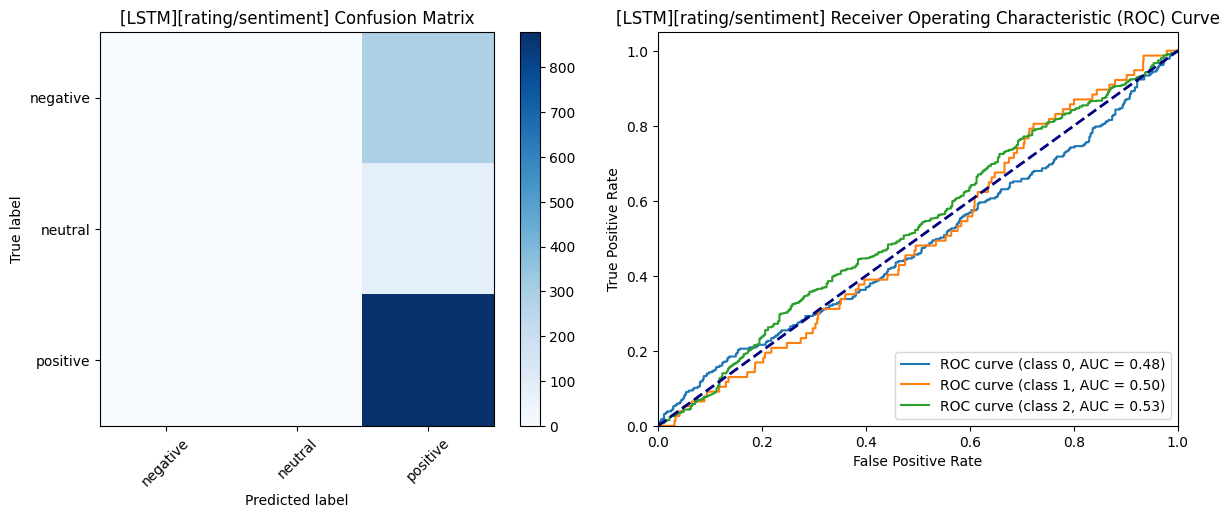

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/2, Train Loss: 0.7846, Test Loss: 0.7401, Train Accuracy: 0.7134, Test Accuracy: 0.7313


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/2, Train Loss: 0.6912, Test Loss: 0.7178, Train Accuracy: 0.7486, Test Accuracy: 0.7313


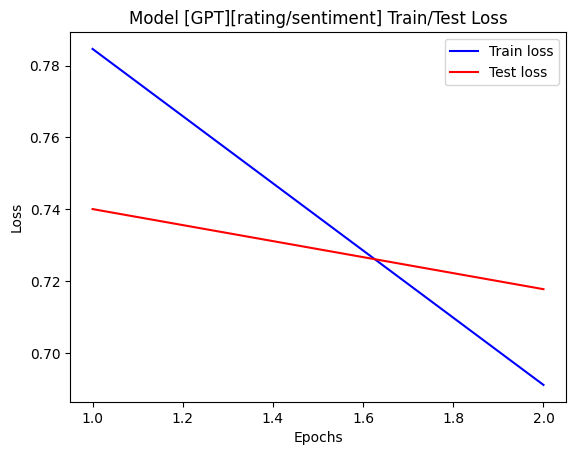

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[GPT][rating/sentiment] Accuracy:		 0.7312952534191473
[GPT][rating/sentiment] Balanced Accuracy:	 0.3333333333333333
[GPT][rating/sentiment] F1 Score:		 0.6177949678048372
[GPT][rating/sentiment] Precision:		 0.8034974942542276
[GPT][rating/sentiment] Recall:			 0.7312952534191473
[GPT][rating/sentiment] Confusion Matrix:		
[[  0   0 260]
 [  0   0  74]
 [  0   0 909]]


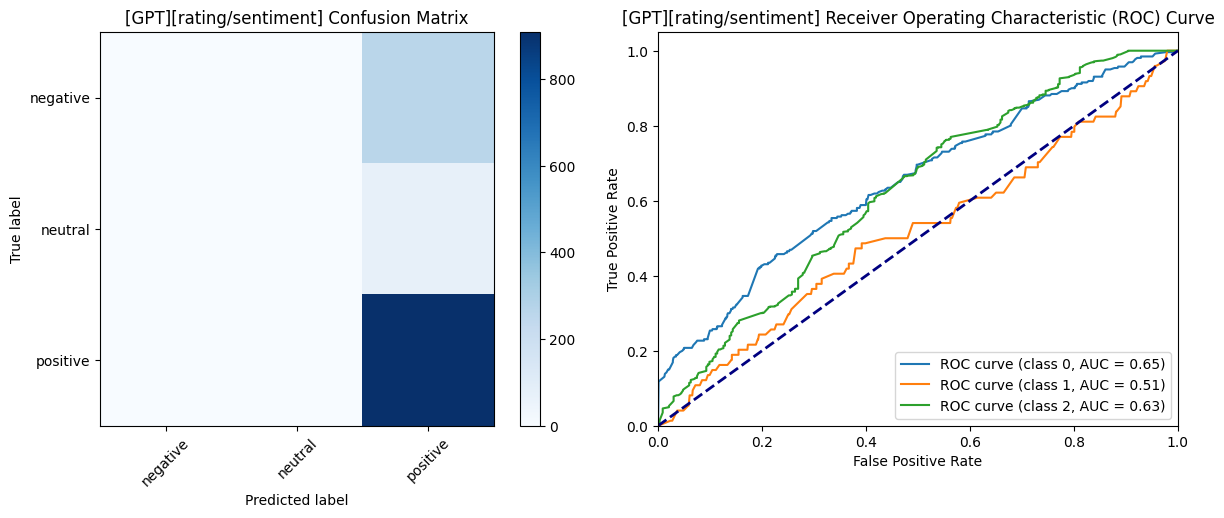

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/2, Train Loss: 0.8276, Test Loss: 0.6928, Train Accuracy: 0.6993, Test Accuracy: 0.7474


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/2, Train Loss: 0.8042, Test Loss: 0.7978, Train Accuracy: 0.7045, Test Accuracy: 0.7474


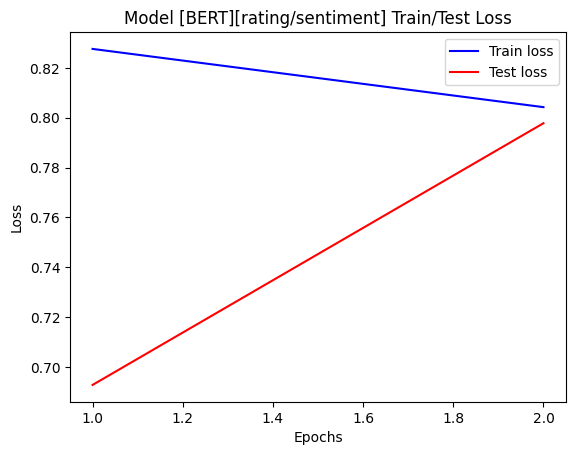

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[BERT][rating/sentiment] Accuracy:		 0.7473853580048271
[BERT][rating/sentiment] Balanced Accuracy:	 0.3333333333333333
[BERT][rating/sentiment] F1 Score:		 0.6393379351625086
[BERT][rating/sentiment] Precision:		 0.8111995153551765
[BERT][rating/sentiment] Recall:			 0.7473853580048271
[BERT][rating/sentiment] Confusion Matrix:		
[[  0   0 249]
 [  0   0  65]
 [  0   0 929]]


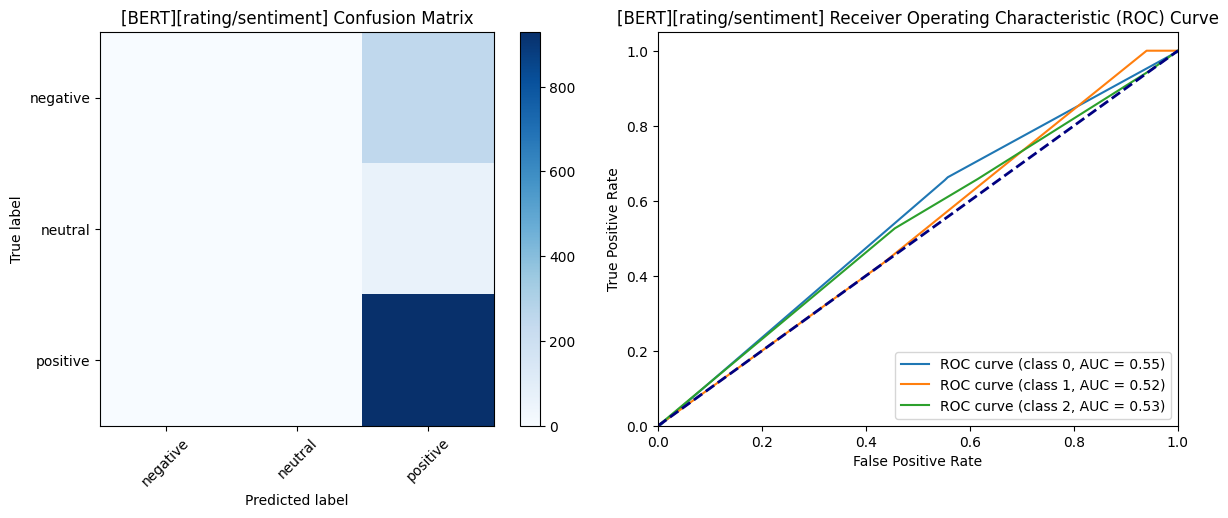

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/2, Train Loss: 0.7938, Test Loss: 0.7849, Train Accuracy: 0.7707, Test Accuracy: 0.7675
Epoch 2/2, Train Loss: 0.7706, Test Loss: 0.7832, Train Accuracy: 0.7848, Test Accuracy: 0.7675


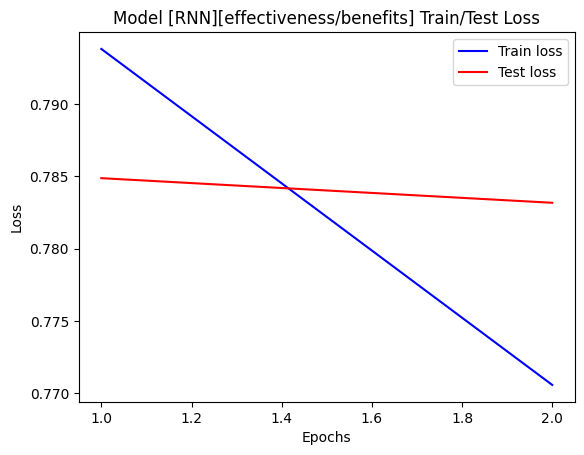

[RNN][effectiveness/benefits] Accuracy:		 0.7674979887369268
[RNN][effectiveness/benefits] Balanced Accuracy:	 0.3322884012539185
[RNN][effectiveness/benefits] F1 Score:		 0.6689395038444799
[RNN][effectiveness/benefits] Precision:		 0.5928132164820331
[RNN][effectiveness/benefits] Recall:			 0.7674979887369268
[RNN][effectiveness/benefits] Confusion Matrix:		
[[954   1   2]
 [ 99   0   0]
 [186   1   0]]


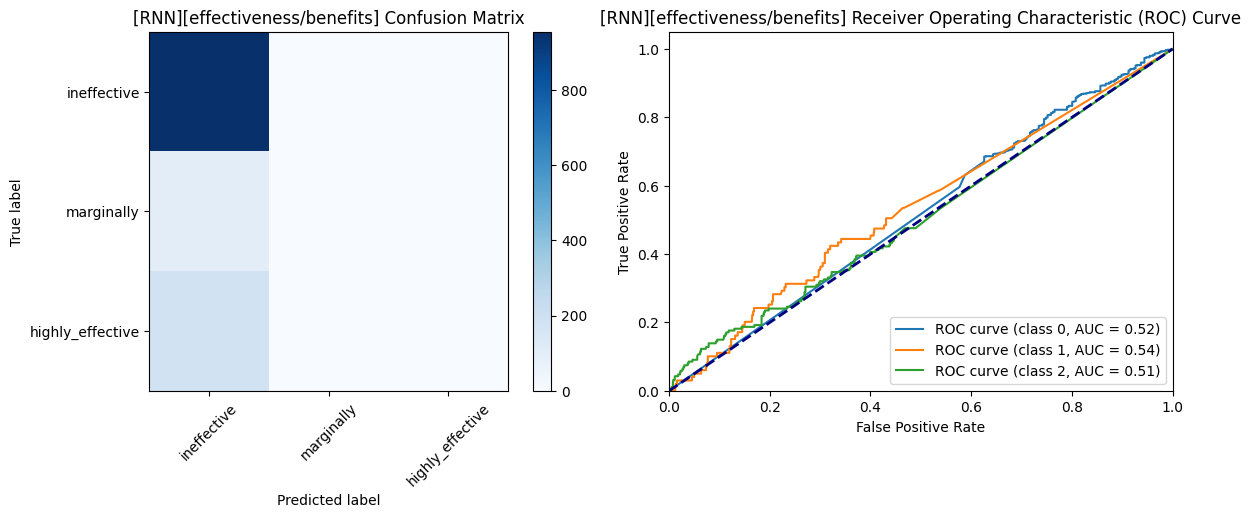




Epoch 1/2, Train Loss: 0.7056, Test Loss: 0.6892, Train Accuracy: 0.7752, Test Accuracy: 0.7675
Epoch 2/2, Train Loss: 0.6764, Test Loss: 0.6948, Train Accuracy: 0.7869, Test Accuracy: 0.7675


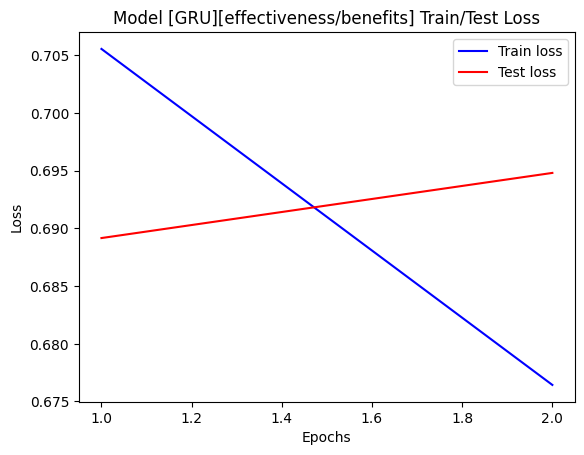

[GRU][effectiveness/benefits] Accuracy:		 0.7674979887369268
[GRU][effectiveness/benefits] Balanced Accuracy:	 0.3337226217550761
[GRU][effectiveness/benefits] F1 Score:		 0.6701263510137045
[GRU][effectiveness/benefits] Precision:		 0.6428176571785305
[GRU][effectiveness/benefits] Recall:			 0.7674979887369268
[GRU][effectiveness/benefits] Confusion Matrix:		
[[953   2   2]
 [ 99   0   0]
 [186   0   1]]


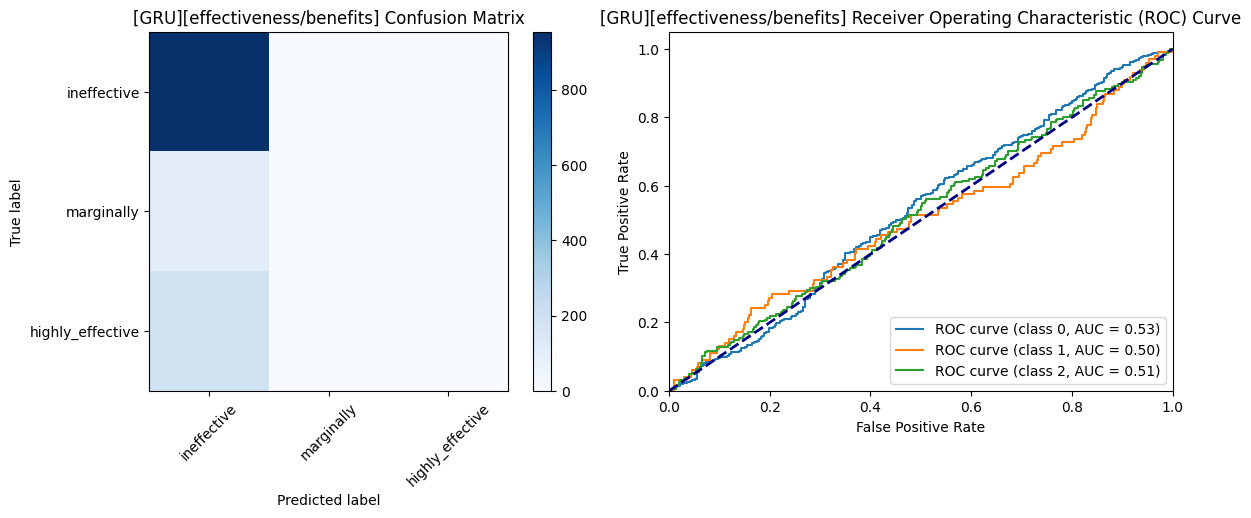




Epoch 1/2, Train Loss: 0.6924, Test Loss: 0.6923, Train Accuracy: 0.7879, Test Accuracy: 0.7699
Epoch 2/2, Train Loss: 0.6671, Test Loss: 0.6884, Train Accuracy: 0.7879, Test Accuracy: 0.7699


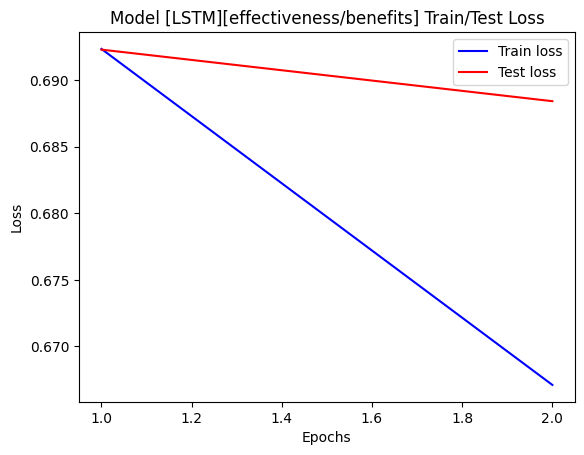

[LSTM][effectiveness/benefits] Accuracy:		 0.7699115044247787
[LSTM][effectiveness/benefits] Balanced Accuracy:	 0.3333333333333333
[LSTM][effectiveness/benefits] F1 Score:		 0.6698230088495575
[LSTM][effectiveness/benefits] Precision:		 0.8228522202208474
[LSTM][effectiveness/benefits] Recall:			 0.7699115044247787
[LSTM][effectiveness/benefits] Confusion Matrix:		
[[957   0   0]
 [ 99   0   0]
 [187   0   0]]


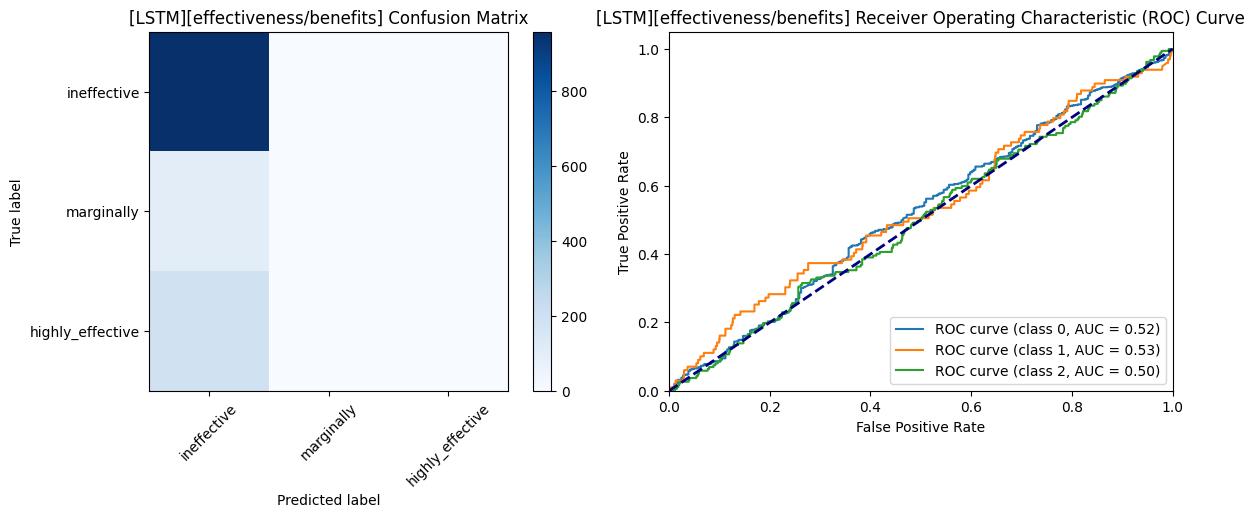

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/2, Train Loss: 0.6378, Test Loss: 0.7138, Train Accuracy: 0.7945, Test Accuracy: 0.7812


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/2, Train Loss: 0.5828, Test Loss: 0.6773, Train Accuracy: 0.8038, Test Accuracy: 0.7949


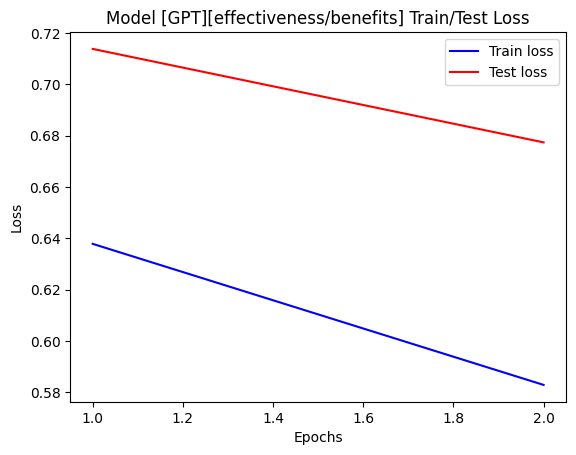

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[GPT][effectiveness/benefits] Accuracy:		 0.7948511665325825
[GPT][effectiveness/benefits] Balanced Accuracy:	 0.411856703307927
[GPT][effectiveness/benefits] F1 Score:		 0.7195896272441282
[GPT][effectiveness/benefits] Precision:		 0.8221205694035358
[GPT][effectiveness/benefits] Recall:			 0.7948511665325825
[GPT][effectiveness/benefits] Confusion Matrix:		
[[962   5   0]
 [ 82  26   0]
 [166   2   0]]


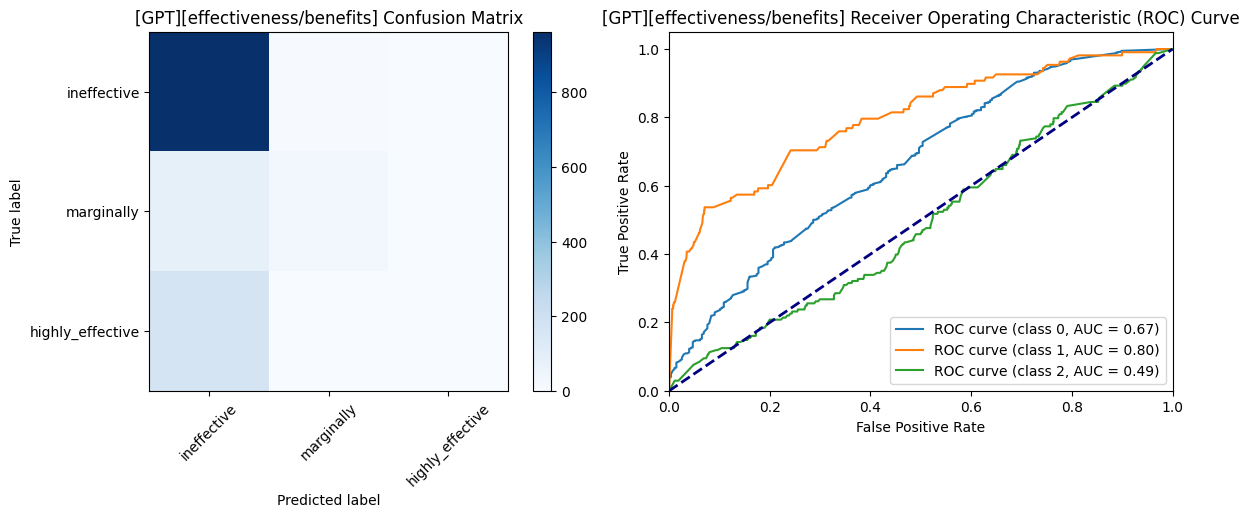

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/2, Train Loss: 0.7333, Test Loss: 0.8936, Train Accuracy: 0.7797, Test Accuracy: 0.7844


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/2, Train Loss: 0.7228, Test Loss: 0.6803, Train Accuracy: 0.7800, Test Accuracy: 0.7844


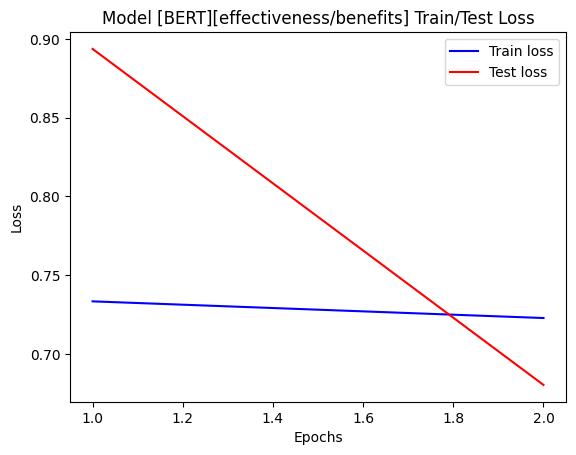

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[BERT][effectiveness/benefits] Accuracy:		 0.7843925985518906
[BERT][effectiveness/benefits] Balanced Accuracy:	 0.3333333333333333
[BERT][effectiveness/benefits] F1 Score:		 0.6896147732985513
[BERT][effectiveness/benefits] Precision:		 0.8308791501110969
[BERT][effectiveness/benefits] Recall:			 0.7843925985518906
[BERT][effectiveness/benefits] Confusion Matrix:		
[[975   0   0]
 [101   0   0]
 [167   0   0]]


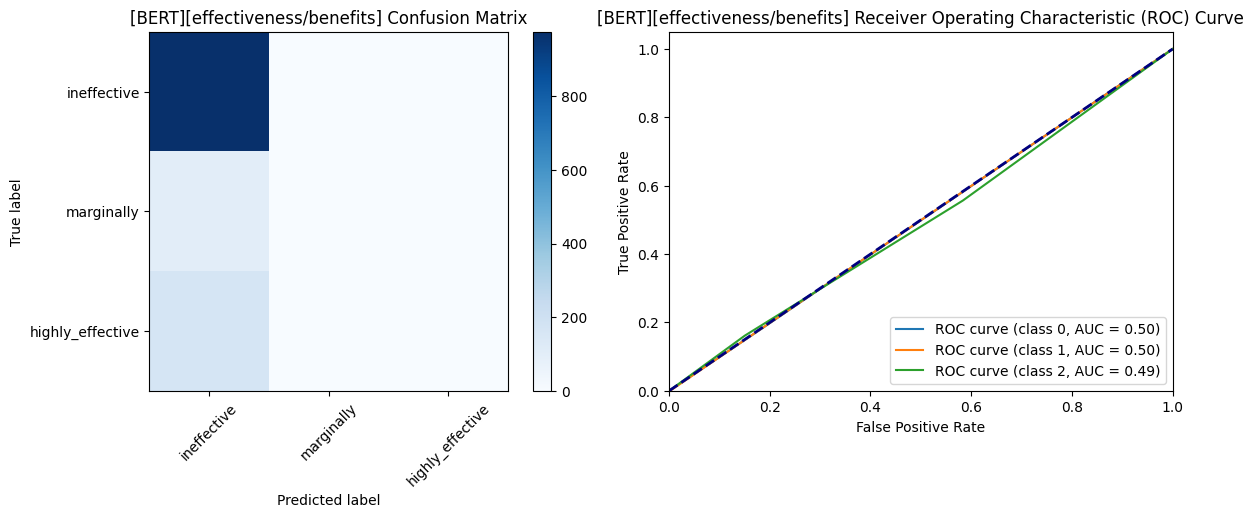

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/2, Train Loss: 0.6182, Test Loss: 0.5871, Train Accuracy: 0.6938, Test Accuracy: 0.7337
Epoch 2/2, Train Loss: 0.6111, Test Loss: 0.5845, Train Accuracy: 0.7007, Test Accuracy: 0.7345


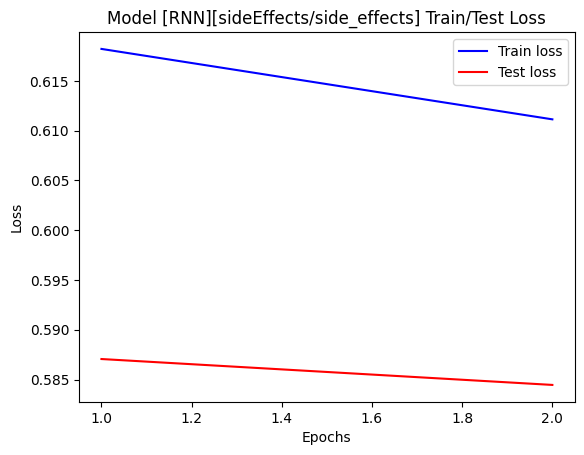

[RNN][sideEffects/side_effects] Accuracy:		 0.7345132743362832
[RNN][sideEffects/side_effects] Balanced Accuracy:	 0.5
[RNN][sideEffects/side_effects] F1 Score:		 0.6220877731623623
[RNN][sideEffects/side_effects] Precision:		 0.8049964758399248
[RNN][sideEffects/side_effects] Recall:			 0.7345132743362832
[RNN][sideEffects/side_effects] Confusion Matrix:		
[[  0 330]
 [  0 913]]


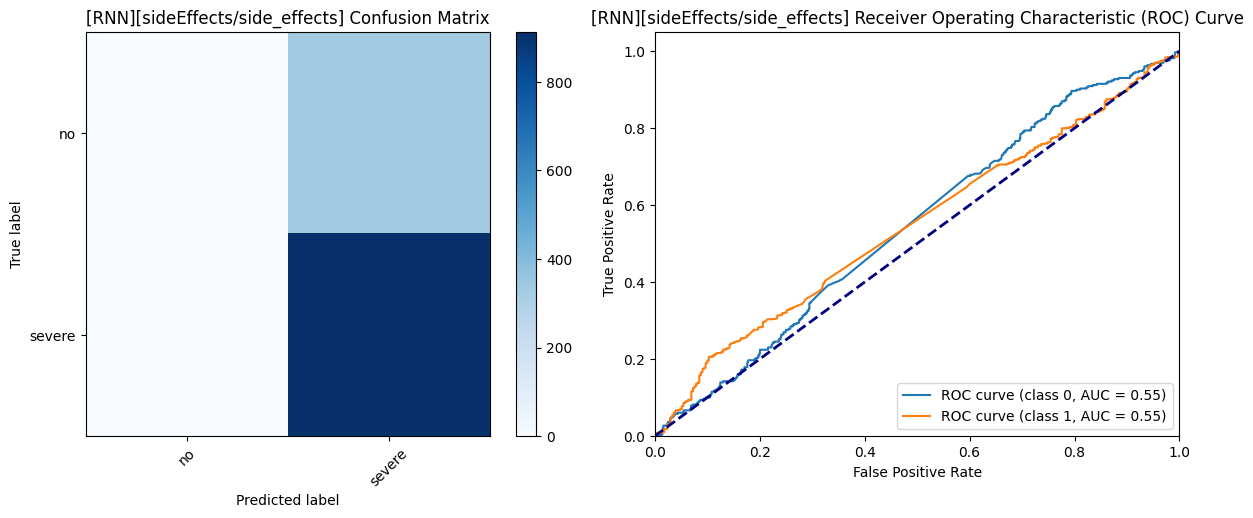




Epoch 1/2, Train Loss: 0.6204, Test Loss: 0.5872, Train Accuracy: 0.6986, Test Accuracy: 0.7337
Epoch 2/2, Train Loss: 0.6130, Test Loss: 0.5822, Train Accuracy: 0.7007, Test Accuracy: 0.7345


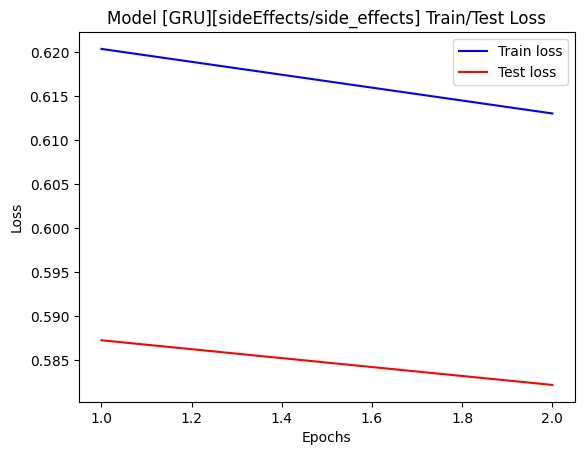

[GRU][sideEffects/side_effects] Accuracy:		 0.7345132743362832
[GRU][sideEffects/side_effects] Balanced Accuracy:	 0.5
[GRU][sideEffects/side_effects] F1 Score:		 0.6220877731623623
[GRU][sideEffects/side_effects] Precision:		 0.8049964758399248
[GRU][sideEffects/side_effects] Recall:			 0.7345132743362832
[GRU][sideEffects/side_effects] Confusion Matrix:		
[[  0 330]
 [  0 913]]


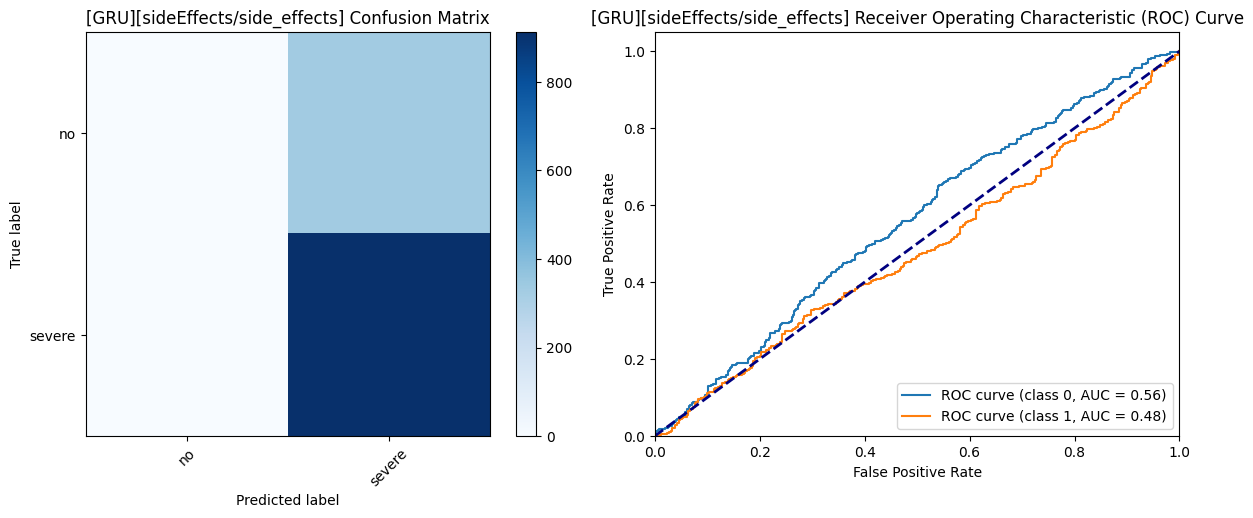




Epoch 1/2, Train Loss: 0.6137, Test Loss: 0.5867, Train Accuracy: 0.7007, Test Accuracy: 0.7345
Epoch 2/2, Train Loss: 0.6073, Test Loss: 0.5779, Train Accuracy: 0.7007, Test Accuracy: 0.7345


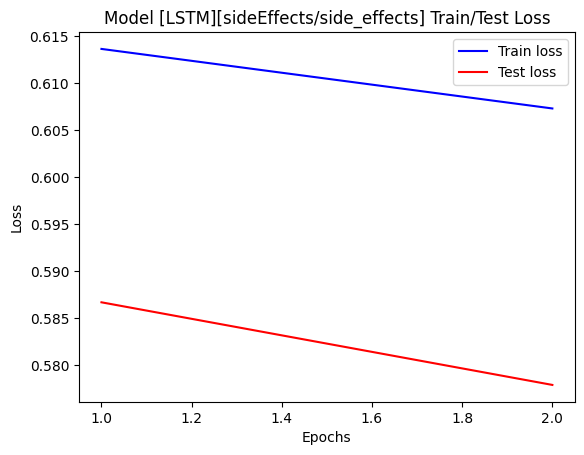

[LSTM][sideEffects/side_effects] Accuracy:		 0.7345132743362832
[LSTM][sideEffects/side_effects] Balanced Accuracy:	 0.5
[LSTM][sideEffects/side_effects] F1 Score:		 0.6220877731623623
[LSTM][sideEffects/side_effects] Precision:		 0.8049964758399248
[LSTM][sideEffects/side_effects] Recall:			 0.7345132743362832
[LSTM][sideEffects/side_effects] Confusion Matrix:		
[[  0 330]
 [  0 913]]


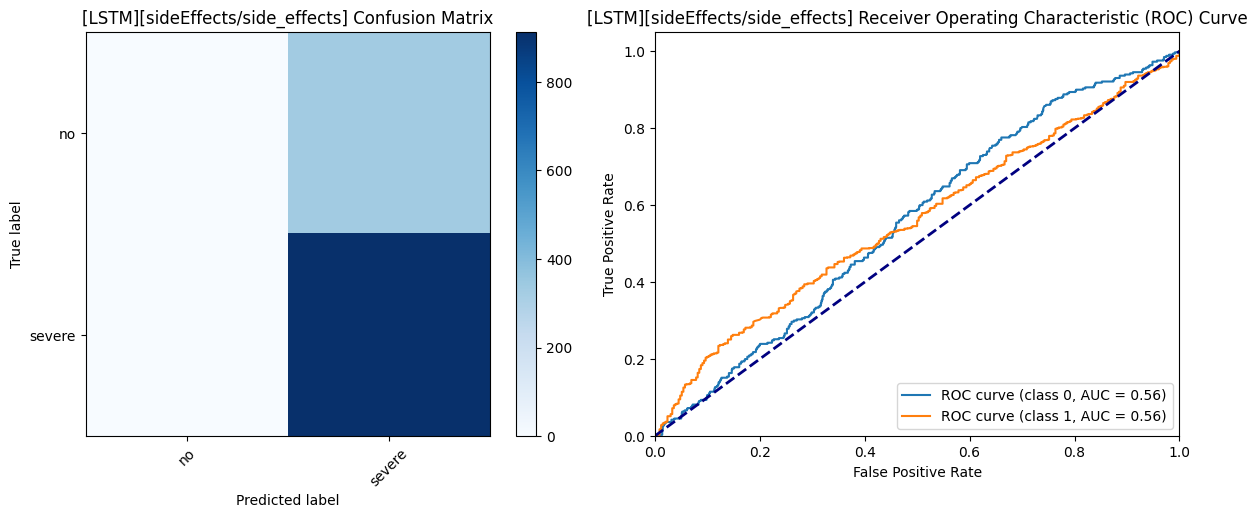

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/2, Train Loss: 0.6146, Test Loss: 0.6313, Train Accuracy: 0.7076, Test Accuracy: 0.7088


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/2, Train Loss: 0.6048, Test Loss: 0.5893, Train Accuracy: 0.7121, Test Accuracy: 0.7257


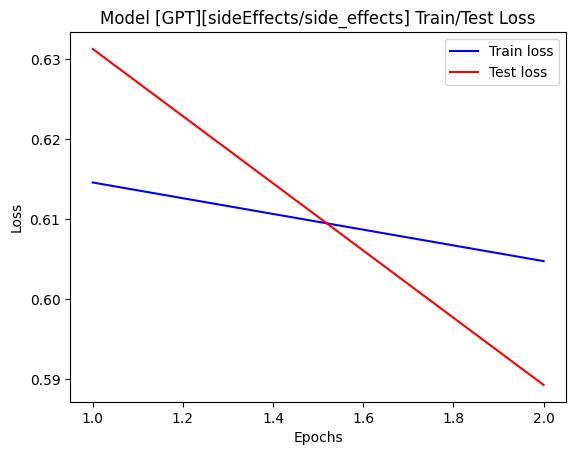

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[GPT][sideEffects/side_effects] Accuracy:		 0.7256637168141593
[GPT][sideEffects/side_effects] Balanced Accuracy:	 0.5363286320793171
[GPT][sideEffects/side_effects] F1 Score:		 0.6364262091529522
[GPT][sideEffects/side_effects] Precision:		 0.7373515556269209
[GPT][sideEffects/side_effects] Recall:			 0.7256637168141593
[GPT][sideEffects/side_effects] Confusion Matrix:		
[[ 30 332]
 [  9 872]]


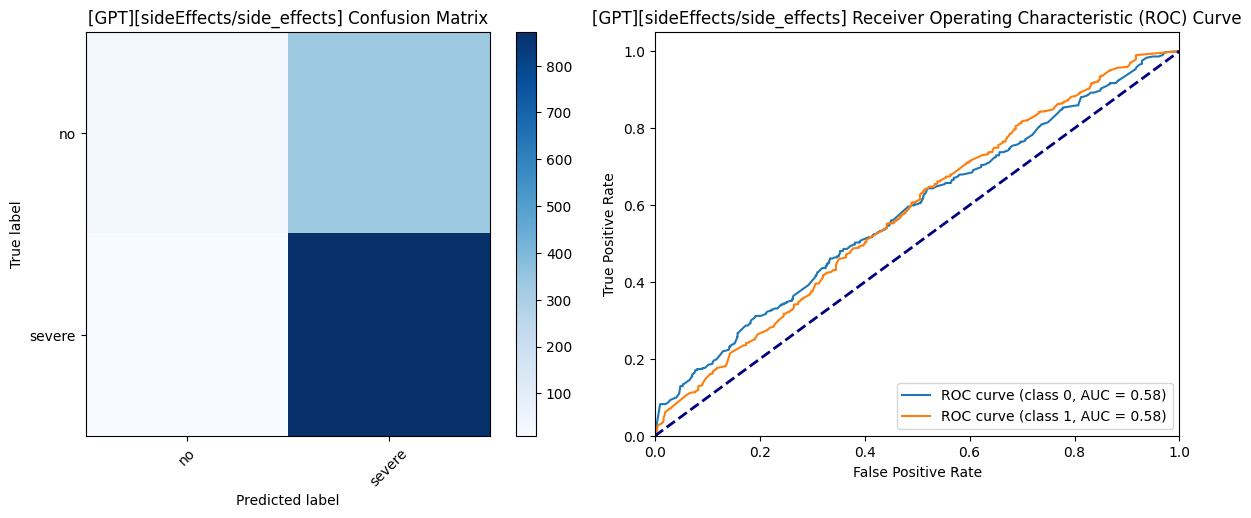

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/2, Train Loss: 0.6623, Test Loss: 0.6218, Train Accuracy: 0.6776, Test Accuracy: 0.7072


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/2, Train Loss: 0.6505, Test Loss: 0.8377, Train Accuracy: 0.6897, Test Accuracy: 0.7072


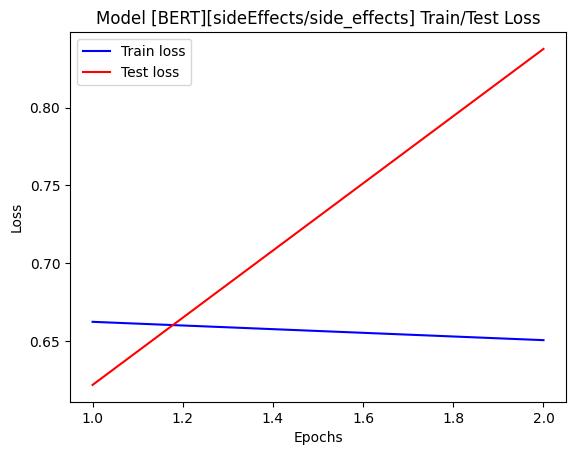

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[BERT][sideEffects/side_effects] Accuracy:		 0.7071600965406275
[BERT][sideEffects/side_effects] Balanced Accuracy:	 0.5
[BERT][sideEffects/side_effects] F1 Score:		 0.5858564796034039
[BERT][sideEffects/side_effects] Precision:		 0.792915305598722
[BERT][sideEffects/side_effects] Recall:			 0.7071600965406275
[BERT][sideEffects/side_effects] Confusion Matrix:		
[[  0 364]
 [  0 879]]


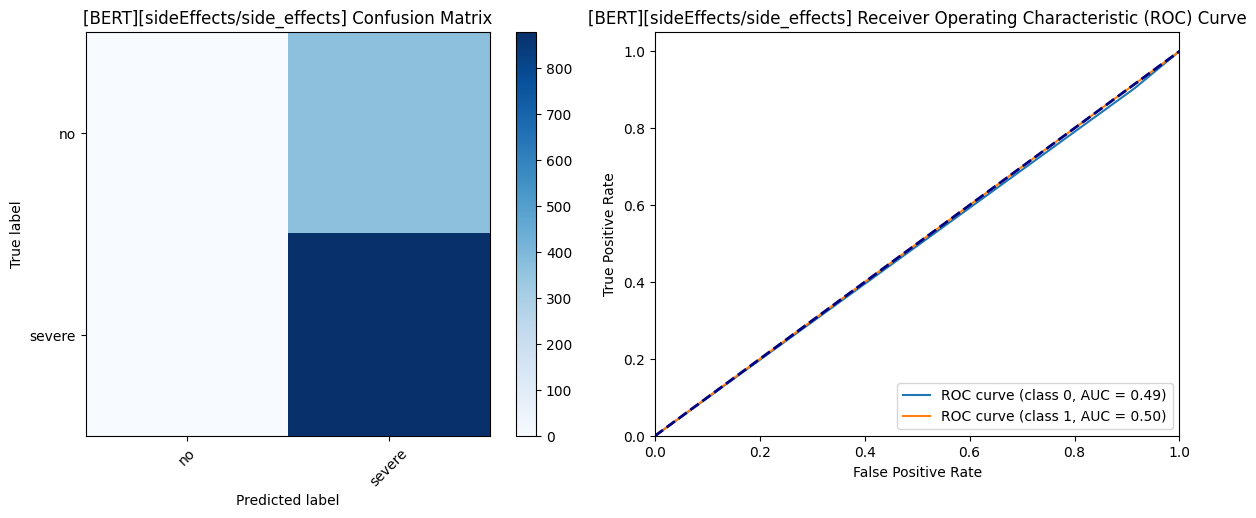

In [36]:
for i in range(0,6,2):
  for model_type in model_classes.keys():
      model_class = model_classes[model_type]
      if model_type in ['RNN', 'GRU', 'LSTM']:
        model = model_class(VOCABULARY_SIZE, INPUT_SIZE, HIDDEN_LAYER_SIZE, nclasses_[i//2]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()
        train_losses, test_losses, y_train_pred, y_test_pred = train_test(model, loaders[i], loaders[i+1], optimizer, criterion, num_epochs=EPOCHS)
        y_test_pred_ = evaluate(model, X_[i+1])

        plotTrainTestCurves(train_losses, test_losses, model_type, i)
        plot_metrics(y_tensor_[i+1], y_test_pred, y_test_pred_, labels_unique[i//2], nclasses_[i//2], model_type, i)

      else:
         model = model_class(models[model_type], nclasses_[i//2]).to(device)
         optimizer = optim.AdamW(model.parameters())
         criterion = nn.CrossEntropyLoss()
         scaler = GradScaler()
         train_lostt, test_loss, y_train_pred, y_test_pred = test_train_pretrained(model,loader[model_type][i], loader[model_type][i+1], optimizer, criterion, scaler, 2)
         plotTrainTestCurves(train_lostt, test_loss, model_type, i)
         evaluate_model(model, loader[model_type][i+1], device, labels_unique[i//2], nclasses_[i//2], model_type, i)
      torch.cuda.empty_cache()



Із отриманих результатів бачимо, що усі моделі мали результати класифікації даних не нижче 70%.

## Висновок

У процесі виконання першої частини лабораторної роботи № 3 було спроектовано та натреновано/протестовано моделі RNN, GRU та LSTM з двома шарами, і pretrained моделі GPT2, BERT для класифікації метрик 'rating', 'effectiveness', 'sideEffects' на основі тексту описів/відгуків згрупованих та токенізованих разом у словники власними і загруженими токенізаторами.

Окрім цього наведені метрики були попередньо підготовлені і згруповані на меншу кількість класів відповідно до їхнього семантичного значення та sentiment аналізу колонок і значень в датасеті Druglib.com, за яким їх можна було згрупувати. В результаті групування із 10 категорій для рейтингу було отримано 3, аналогічно і для ефективності, а для сторонніх ефектиів було сторино лише 2 класи, а саме чи мала людина при прийомі препарату побічні ефекти чи ні.

 В результаті роботи усіх моделей для кожної з метрик була досягнута точність класифікації на тестових даних не нижче 70%, що є достатнім показником точності класифікації.

 Найкращі результати класифікації мали наступні моделі:


*   Колонка 'rating/sentiment' - модель BERT з точністю acc = 0.74 для тестових даних
*   Колонка 'effectiveness/benefits' - модель GPT2 з точністю acc = 0.78 для тестових даних
*   Колонка 'sideEffects/side_effects' - модель LSTM з точністю acc = 0.73 для тестових даних

Отже із отриманих результатів, можемо сказати, що навіть при згрупованих даних та використанні спрощеної(найменшої за кількістю гіперпараметрів) pretrained моделі GPT2 та BERT мають кращі результати класифікації ніж створені в ручну моделі RNN, GRU, LSTM, для колонок sentiment, benefits, а у свою чергу LSTM та інші моделі показали себе краще на бінарній класифікації.

  

<div align="left">
    <h4><b>Виконав:</b></h4>
    <h4>студент</h4>
    <h4>Орлянський Максим</h4>
    <h4><b>Група:</b></h4>
    <h4>КН-317</h4>
    <h4><b>Прийняв:</b></h4>
    <h4>асистент</h4>
    <h4>Гурбич О.В.</h4>
</div>